In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno 
import re
import seaborn as sns
import geopandas as gp
from shapely import wkt

sns.set()

1) Descripcion del dataset

2) Eleccion de departamentos de la zona de CABA

3) Datos nulos

4) Rescate de valores nulos usando regex en:

* Titulo
* Descripción
* URL 

5) Amenities usando regex:
* Pileta
* Cochera
* Parrilla 
* SUM

6) Verificacion de la calidad de los datos

7) Visualizacion de distribucion de los datos

8) Tratamiento de valores minimos y outliers 

9) Imputacion de valores nulos en las columnas seleccionadas

10) Cercanias con diferentes puntos de la ciudad

11) Dummies de variables categoricas

12) Correlacion de variables

13) Modelos de regresion

14) Matriz de R2 de cada modelo



In [183]:
data = pd.read_csv('../Workshop/data/properati.csv', index_col=0)
data.head(3)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   operation                   121220 non-null  object 
 1   property_type               121220 non-null  object 
 2   place_name                  121197 non-null  object 
 3   place_with_parent_names     121220 non-null  object 
 4   country_name                121220 non-null  object 
 5   state_name                  121220 non-null  object 
 6   geonames_id                 102503 non-null  float64
 7   lat-lon                     69670 non-null   object 
 8   lat                         69670 non-null   float64
 9   lon                         69670 non-null   float64
 10  price                       100810 non-null  float64
 11  currency                    100809 non-null  object 
 12  price_aprox_local_currency  100810 non-null  float64
 13  price_aprox_us

In [185]:
data.shape

(121220, 25)

### 2) Eleccion de departamentos en la zona de CABA

In [186]:
mask_apto_usd_caba = (data['property_type'] == 'apartment') & \
                     (data['currency'] == 'USD') & \
                     (data['state_name'] == 'Capital Federal')

caba = data.loc[mask_apto_usd_caba,:]

### 3) Cantidad de datos nulos del dataset CABA

In [187]:
caba.isnull().sum()/caba.shape[0]*100

operation                      0.000000
property_type                  0.000000
place_name                     0.000000
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                    4.238025
lat-lon                       23.719899
lat                           23.719899
lon                           23.719899
price                          0.000000
currency                       0.000000
price_aprox_local_currency     0.000000
price_aprox_usd                0.000000
surface_total_in_m2           17.695384
surface_covered_in_m2          5.459445
price_usd_per_m2              17.751891
price_per_m2                   5.468139
floor                         88.389985
rooms                         45.483787
expenses                      74.198035
properati_url                  0.000000
description                    0.000000
title                          0.000000
image_thumbnail                1.151873


### 4)Imputacion de  datos faltates usando regex

Los datos faltantes que vamos a utilizar, vamos a buscar usando expresiones regulares en las columnas de 'Title', 'Description' y 'URL' del dataframe.

#### Superficie

In [188]:
print('Porcentaje de datos nulos en superficie total antes:', (caba.surface_total_in_m2.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en superficie total antes: 17.7 %


In [189]:
patron = '.*(?P<m2_total>\d{3})(\s?[m]|\s[ms]|\s?[m2]|\s?[metros]|\s?[m^2])'
regex = re.compile(patron, re.IGNORECASE)
    
    #Description
regular = caba[caba.surface_total_in_m2.isnull()].description.apply(lambda x: x if x is np.nan else regex.search(x))
serie = regular.apply(lambda x: x if x is None or x is np.nan else x.group('m2_total')).astype('float64')
data.surface_total_in_m2.fillna(serie, inplace=True)

In [190]:
patron = '.*(?P<m2_total>\d{3})(\s?[m]|\s[ms]|\s?[m2]|\s?[metros]|\s?[m^2])'
regex = re.compile(patron, re.IGNORECASE)
    
    #Title
regular = caba[caba.surface_total_in_m2.isnull()].title.apply(lambda x: x if x is np.nan else regex.search(x))
serie = regular.apply(lambda x: x if x is None or x is np.nan else x.group('m2_total')).astype('float64')
data.surface_total_in_m2.fillna(serie, inplace=True)

In [191]:
print('Porcentaje de datos nulos en superficie total despues de regex:', (caba.surface_total_in_m2.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en superficie total despues de regex: 17.7 %


#### Room

In [192]:
print('Porcentaje de datos nulos en superficie total antes:', (caba.rooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en superficie total antes: 45.48 %


In [193]:
pattern_ambientes = r'(?P<amb>\d+)(\s)(\b(ambientes|ambiente|amb|cuarto|cuartos|habitacion|habitaciones|dormitorio|dormitorios|dorm|hab)\b)'
pattern_ambientes_regex = re.compile(pattern_ambientes)
description_series = caba.title.astype(str)
resultado_ambientes = description_series.apply(lambda x: x if x is np.nan else pattern_ambientes_regex.search(x))
ambientes_match = resultado_ambientes.apply(lambda x: x if x is None else x.group('amb'))

caba['rooms'] = caba['rooms'].fillna(ambientes_match)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [194]:
pattern_ambientes = r'(?P<amb>\d+)(\s)(\b(ambientes|ambiente|amb|cuarto|cuartos|habitacion|habitaciones|dormitorio|dormitorios|dorm|hab)\b)'
pattern_ambientes_regex = re.compile(pattern_ambientes)
description_series = caba.description.astype(str)
resultado_ambientes = description_series.apply(lambda x: x if x is np.nan else pattern_ambientes_regex.search(x))
ambientes_match = resultado_ambientes.apply(lambda x: x if x is None else x.group('amb'))

caba['rooms'] = caba['rooms'].fillna(ambientes_match)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [195]:
pattern_ambientes = r'(?P<amb>\d+)(\s)(\b(ambientes|ambiente|amb|cuarto|cuartos|habitacion|habitaciones|dormitorio|dormitorios|dorm|hab)\b)'
pattern_ambientes_regex = re.compile(pattern_ambientes)
description_series = caba.properati_url.astype(str)
resultado_ambientes = description_series.apply(lambda x: x if x is np.nan else pattern_ambientes_regex.search(x))
ambientes_match = resultado_ambientes.apply(lambda x: x if x is None else x.group('amb'))

caba['rooms'] = caba['rooms'].fillna(ambientes_match)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [196]:
print('Porcentaje de datos nulos en superficie total despues de regex:', (caba.rooms.isnull().sum()/caba.shape[0]*100).round(2), '%')

Porcentaje de datos nulos en superficie total despues de regex: 25.38 %


In [ ]:
caba.rooms.value_counts() #Encontramos floats y int

In [198]:
caba.rooms.fillna(0, inplace=True) #Valores nan con 0 para eliminar los floats para que los datos esten uniformes. 
                                   #Valores nan se dara tratamiento en la seccion 9
caba.rooms = pd.to_numeric(caba.rooms, downcast='integer')

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [199]:
caba.rooms.value_counts()

0     5840
2     4708
3     4501
1     3802
4     3046
5      733
6      196
7       98
8       37
9       15
10      10
12       8
11       4
14       3
17       3
15       1
22       1
Name: rooms, dtype: int64

### Amenities

#### Pileta

In [200]:
pattern_pileta = "(?P<pile>[pP]ileta)"
pattern_pileta_regex = re.compile(pattern_pileta)
description_series = caba.title.astype(str)
resultado_pileta = description_series.apply(lambda x: x if x is np.nan else pattern_pileta_regex.search(x))
pileta_match = resultado_pileta.apply(lambda x: x if x is None else x.group('pile'))

pileta_match.replace('pileta', 'Pileta', inplace = True)

caba['Pileta'] = pileta_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [201]:
pattern_pileta = "(?P<pile>[pP]ileta)"
pattern_pileta_regex = re.compile(pattern_pileta)
description_series = caba.description.astype(str)
resultado_pileta = description_series.apply(lambda x: x if x is np.nan else pattern_pileta_regex.search(x))
pileta_match = resultado_pileta.apply(lambda x: x if x is None else x.group('pile'))

pileta_match.replace('pileta', 'Pileta', inplace = True)

caba['Pileta'] = pileta_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [202]:
pattern_pileta = "(?P<pile>[pP]ileta)"
pattern_pileta_regex = re.compile(pattern_pileta)
description_series = caba.properati_url.astype(str)
resultado_pileta = description_series.apply(lambda x: x if x is np.nan else pattern_pileta_regex.search(x))
pileta_match = resultado_pileta.apply(lambda x: x if x is None else x.group('pile'))

pileta_match.replace('pileta', 'Pileta', inplace = True)

caba['Pileta'] = pileta_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#### Chochera

In [203]:
pattern_cochera = "(?P<coch>[cC]ochera)"
pattern_cochera_regex = re.compile(pattern_cochera)
description_series = caba.title.astype(str)
resultado_cochera = description_series.apply(lambda x: x if x is np.nan else pattern_cochera_regex.search(x))
cochera_match = resultado_cochera.apply(lambda x: x if x is None else x.group('coch'))

pileta_match.replace('cochera', 'Cochera', inplace = True)
caba['Cochera'] = cochera_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [204]:
pattern_cochera = "(?P<coch>[cC]ochera)"
pattern_cochera_regex = re.compile(pattern_cochera)
description_series = caba.description.astype(str)
resultado_cochera = description_series.apply(lambda x: x if x is np.nan else pattern_cochera_regex.search(x))
cochera_match = resultado_cochera.apply(lambda x: x if x is None else x.group('coch'))

pileta_match.replace('cochera', 'Cochera', inplace = True)
caba['Cochera'] = cochera_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [205]:
pattern_cochera = "(?P<coch>[cC]ochera)"
pattern_cochera_regex = re.compile(pattern_cochera)
description_series = caba.properati_url.astype(str)
resultado_cochera = description_series.apply(lambda x: x if x is np.nan else pattern_cochera_regex.search(x))
cochera_match = resultado_cochera.apply(lambda x: x if x is None else x.group('coch'))

pileta_match.replace('cochera', 'Cochera', inplace = True)
caba['Cochera'] = cochera_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Parrilla

In [207]:
pattern_parrilla = "(?P<parri>[pP]arrilla)"
pattern_parrilla_regex = re.compile(pattern_parrilla)
description_series = caba.title.astype(str)
resultado_parrilla = description_series.apply(lambda x: x if x is np.nan else pattern_parrilla_regex.search(x))
parrilla_match = resultado_parrilla.apply(lambda x: x if x is None else x.group('parri'))

parrilla_match.replace('parrilla', 'Parrilla', inplace = True)
caba['Parrilla'] = parrilla_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [208]:
pattern_parrilla = "(?P<parri>[pP]arrilla)"
pattern_parrilla_regex = re.compile(pattern_parrilla)
description_series = caba.description.astype(str)
resultado_parrilla = description_series.apply(lambda x: x if x is np.nan else pattern_parrilla_regex.search(x))
parrilla_match = resultado_parrilla.apply(lambda x: x if x is None else x.group('parri'))

parrilla_match.replace('parrilla', 'Parrilla', inplace = True)
caba['Parrilla'] = parrilla_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [209]:
pattern_parrilla = "(?P<parri>[pP]arrilla)"
pattern_parrilla_regex = re.compile(pattern_parrilla)
description_series = caba.properati_url.astype(str)
resultado_parrilla = description_series.apply(lambda x: x if x is np.nan else pattern_parrilla_regex.search(x))
parrilla_match = resultado_parrilla.apply(lambda x: x if x is None else x.group('parri'))

parrilla_match.replace('parrilla', 'Parrilla', inplace = True)
caba['Parrilla'] = parrilla_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### SUM

In [211]:
pattern_sum = "(?P<sum>sum)"
pattern_sum_regex = re.compile(pattern_sum, re.IGNORECASE)
description_series = caba.title.astype(str)
resultado_sum = description_series.apply(lambda x: x if x is np.nan else pattern_sum_regex.search(x))
sum_match = resultado_sum.apply(lambda x: x if x is None else x.group('sum'))

sum_match.replace('sum', 'SUM', inplace = True)
caba['sum'] = sum_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
pattern_sum = "(?P<sum>sum)"
pattern_sum_regex = re.compile(pattern_sum, re.IGNORECASE)
description_series = caba.description.astype(str)
resultado_sum = description_series.apply(lambda x: x if x is np.nan else pattern_sum_regex.search(x))
sum_match = resultado_sum.apply(lambda x: x if x is None else x.group('sum'))

sum_match.replace('sum', 'SUM', inplace = True)
caba['sum'] = sum_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [213]:
pattern_sum = "(?P<sum>sum)"
pattern_sum_regex = re.compile(pattern_sum, re.IGNORECASE)
description_series = caba.properati_url.astype(str)
resultado_sum = description_series.apply(lambda x: x if x is np.nan else pattern_sum_regex.search(x))
sum_match = resultado_sum.apply(lambda x: x if x is None else x.group('sum'))

sum_match.replace('sum', 'SUM', inplace = True)
caba['sum'] = sum_match

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Verificacion de la calidad de los datos

In [215]:
caba.columns

Index(['operation', 'property_type', 'place_name', 'place_with_parent_names',
       'country_name', 'state_name', 'geonames_id', 'lat-lon', 'lat', 'lon',
       'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'Pileta', 'Cochera',
       'Parrilla', 'sum'],
      dtype='object')

In [216]:
all(caba['price'] == caba['price_aprox_usd'])

True

In [217]:
all(caba['price_usd_per_m2'] == caba['price_per_m2'])

False

In [218]:
any(caba['price_usd_per_m2'] == caba['price_per_m2'])

True

In [219]:
any(caba['surface_total_in_m2'] == caba['surface_covered_in_m2'])

True

In [221]:
any(caba['surface_total_in_m2'] < caba['surface_covered_in_m2']) #Vemos que hay datos inconsistentes aqui

True

In [222]:
#Separamos las columnas que vamos a trabajar para analisis posteriores
columns = ['place_name','lat','lon','surface_total_in_m2', 'surface_covered_in_m2',
           'price_per_m2', 'rooms', 'Pileta', 'Cochera', 'Parrilla', 'sum']

In [223]:
caba = caba[columns]
caba.head(2)

,place_name,lat,lon,surface_total_in_m2,surface_covered_in_m2,price_per_m2,rooms,Pileta,Cochera,Parrilla,sum
2,Mataderos,-34.652262,-58.522982,55.0,55.0,1309.090909,0,None,None,None,None
7,Belgrano,-34.559873,-58.443362,45.0,40.0,3450.000000,0,None,None,None,None


In [224]:
caba.loc[caba['surface_total_in_m2'] < caba['surface_covered_in_m2']] #Filtramos los datos que son inconsistentes

,place_name,lat,lon,surface_total_in_m2,surface_covered_in_m2,price_per_m2,rooms,Pileta,Cochera,Parrilla,sum
1397,Balvanera,-34.603133,-58.394624,80.0,89.0,1662.921348,4,None,None,None,None
6312,Caballito,-34.616291,-58.429026,144.0,147.0,1904.761905,0,None,None,None,None
13800,Villa Urquiza,-34.577524,-58.486546,70.0,78.0,2884.615385,0,None,None,None,None
17397,Coghlan,-34.557157,-58.479782,14.0,86.0,2069.767442,0,None,None,None,None
18717,Nuñez,-34.539465,-58.473690,59.0,65.0,2538.461538,2,None,None,None,None
18778,Parque Patricios,-34.629740,-58.398495,63.0,66.0,1242.424242,4,None,None,None,None
21531,Recoleta,-34.593267,-58.412733,10.0,155.0,2129.032258,4,None,None,None,None
22321,Floresta,-34.637886,-58.474408,49.0,52.0,1884.615385,3,None,None,None,None
24894,Congreso,-34.685699,-58.471813,72.0,76.0,1407.894737,3,None,None,None,None
24980,Flores,-34.625645,-58.461116,37.0,41.0,1956.585366,1,None,None,None,None


In [225]:
#Todos aquellos datos donde total < cubierta, vamos a asignarle el valor de la superficie cubierta
caba.loc[caba['surface_total_in_m2'] < caba['surface_covered_in_m2'], ['surface_total_in_m2']] = caba['surface_covered_in_m2'] 

In [226]:
caba.loc[1397:1398] #verificamos que este correcto

,place_name,lat,lon,surface_total_in_m2,surface_covered_in_m2,price_per_m2,rooms,Pileta,Cochera,Parrilla,sum
1397,Balvanera,-34.603133,-58.394624,89.0,89.0,1662.921348,4,None,None,None,None


In [227]:
caba.shape

(23006, 11)

In [228]:
caba.isnull().sum() / caba.shape[0]*100

place_name                 0.000000
lat                       23.719899
lon                       23.719899
surface_total_in_m2       17.695384
surface_covered_in_m2      5.459445
price_per_m2               5.468139
rooms                      0.000000
Pileta                   100.000000
Cochera                  100.000000
Parrilla                  73.389551
sum                       79.040250
dtype: float64

In [229]:
caba.dropna(subset=['surface_total_in_m2', 'surface_covered_in_m2', 'price_per_m2'], inplace=True)

In [230]:
caba.shape

(18043, 11)

In [231]:
caba.isnull().sum() / caba.shape[0]*100

place_name                 0.000000
lat                       25.644294
lon                       25.644294
surface_total_in_m2        0.000000
surface_covered_in_m2      0.000000
price_per_m2               0.000000
rooms                      0.000000
Pileta                   100.000000
Cochera                  100.000000
Parrilla                  72.576623
sum                       77.863992
dtype: float64

### 7) Visualizacion de la distribucion de los datos

count    18043.000000
mean        79.954719
std         70.772126
min         12.000000
25%         41.000000
50%         57.000000
75%         91.000000
max       3673.000000
Name: surface_total_in_m2, dtype: float64


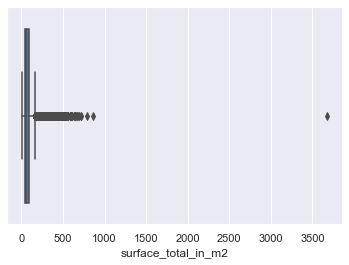

In [232]:
print(caba.surface_total_in_m2.describe())
sns.boxplot(caba.surface_total_in_m2)
plt.show()

count    18043.000000
mean        70.345896
std         63.465683
min          2.000000
25%         37.000000
50%         50.000000
75%         80.000000
max       3673.000000
Name: surface_covered_in_m2, dtype: float64


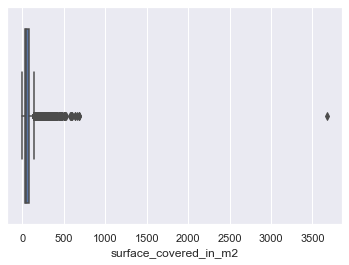

In [233]:
print(caba.surface_covered_in_m2.describe())
sns.boxplot(caba.surface_covered_in_m2)
plt.show()

count     18043.000000
mean       3752.491165
std        4154.071067
min          49.000000
25%        2375.000000
50%        2915.384615
75%        3621.455939
max      206333.333333
Name: price_per_m2, dtype: float64


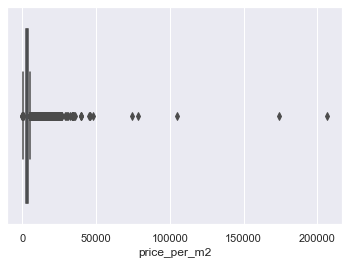

In [234]:
print(caba.price_per_m2.describe())
sns.boxplot(caba.price_per_m2)
plt.show()

### 8) Tratamiento de valores minimos y outliers

Considerante la superficie cubierta, tomamos como valor minimo 18 m2 ya que es el valor minimo establecido por el gobierno de la ciudad y como valor maximo seleccionamos todos los datos del cuartil 99 para eliminar el outlier que vimos en el grafico anterior.

Respecto a precio por m2, tomamos como valor maximo U$S 10.000 ya que es el maximo valor en paginas de ventas de departamentos

In [235]:
LS = caba.surface_covered_in_m2.quantile(0.99)
LI = 18

caba = caba[(caba.surface_covered_in_m2 <= LS) &
            (caba.surface_covered_in_m2 >= LI) &
            (caba.price_per_m2 <= 10000)
            ]

count    17203.000000
mean      3101.302320
std       1198.028687
min         84.615385
25%       2352.941176
50%       2875.000000
75%       3490.312325
max      10000.000000
Name: price_per_m2, dtype: float64


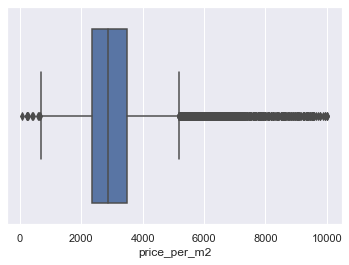

In [236]:
print(caba.price_per_m2.describe())
sns.boxplot(caba.price_per_m2)
plt.show()

count    17203.000000
mean        68.018195
std         47.203348
min         18.000000
25%         38.000000
50%         50.000000
75%         80.000000
max        310.000000
Name: surface_covered_in_m2, dtype: float64


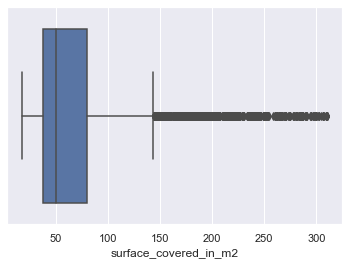

In [237]:
print(caba.surface_covered_in_m2.describe())
sns.boxplot(caba.surface_covered_in_m2)
plt.show()

### 9) Imputacion de valores nulos

In [238]:
#Imputamos la media de lat lon por barrio
caba['lat'] = caba['lat'].fillna(caba.groupby('place_name')['lat'].transform('mean'))
caba['lon'] = caba['lon'].fillna(caba.groupby('place_name')['lon'].transform('mean'))

In [239]:
caba.rooms.replace(0, np.nan, inplace=True)

In [240]:
caba.rooms.isnull().sum() / caba.shape[0] * 100

27.989304191129456

<AxesSubplot:xlabel='rooms', ylabel='surface_covered_in_m2'>

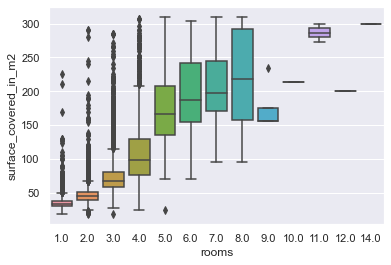

In [241]:
sns.boxplot(data=caba, x='rooms', y='surface_covered_in_m2')

In [242]:
#Usamos qcut para dividir en 6 la superficie cubierta y asignar la cantidad de cuartos en cada division a los nan
labels = ['1', '2', '3', '4', '5', '6']
superficie = pd.qcut(caba.surface_covered_in_m2, 6, labels=labels)
caba['division'] = superficie

a = caba.loc[caba.division == '1'].fillna(value={'rooms': 1})
b = caba.loc[caba.division == '2'].fillna(value={'rooms': 2})
c = caba.loc[caba.division == '3'].fillna(value={'rooms': 3})
d = caba.loc[caba.division == '4'].fillna(value={'rooms': 4})
e = caba.loc[caba.division == '5'].fillna(value={'rooms': 5})
f = caba.loc[caba.division == '6'].fillna(value={'rooms': 6})
caba = pd.concat([a,b,c,d,e,f])
caba.drop(columns='division', inplace=True)

In [243]:
caba.rooms = pd.to_numeric(caba.rooms, downcast='integer')
caba.rooms.value_counts()

2     4521
3     4279
1     3611
4     3022
5     1018
6      652
7       66
8       24
9        4
12       2
11       2
14       1
10       1
Name: rooms, dtype: int64

In [244]:
caba.isnull().sum() / caba.shape[0]*100

place_name                 0.000000
lat                        0.000000
lon                        0.000000
surface_total_in_m2        0.000000
surface_covered_in_m2      0.000000
price_per_m2               0.000000
rooms                      0.000000
Pileta                   100.000000
Cochera                  100.000000
Parrilla                  74.428879
sum                       80.049991
dtype: float64

### 10) Cercania a diferentes puntos de la ciudad

Usamos la formula de Haversiana para determinar la distancia entre los departamentos a la venta con diferentes puntos de la ciudad:
* Estaciones de subte
* Paradas de colectivos
* Paradas de metrobuses
* Estaciones de trenes
* Estaciones de ecobicis
* Espacios culturales
* Espacios gastronimicos
* Universidades
* Polideportivos
* Hospitales
* Comisarias
* Espacios verdes

Se considera que el departamento se encuentra "cerca" de alguno de estos puntos mencionados si su distancia no supera hasta los 2 kms.

#### Formula Haversiana

In [245]:
def haversine_np(lon1, lat1, lon2, lat2):
  
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6361 * c  
    
    return km

#### Subte

In [246]:
subte_path = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/subte-estaciones/estaciones-de-subte.csv"
subte = pd.read_csv(subte_path) 

In [247]:
latlon = caba[['lat','lon']]  
latlon_subte = subte[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_subte['long'],latlon_subte['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'subte'] = "Cerca"
    else:
        latlon_.loc[index, 'subte'] = "Lejos"
caba = pd.concat([caba,latlon_['subte']],axis=1)     

In [248]:
mask_subte = caba['subte'] == "Cerca"
dummies_subte = pd.get_dummies(mask_subte, prefix='subte', drop_first=True)
caba = caba.join(dummies_subte)
caba.drop(columns='subte', inplace=True)

#### Colectivos

In [249]:
bondis_path = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/colectivos/paradas-de-colectivo.csv"
bondis = pd.read_csv(bondis_path) 

In [250]:
bondis = bondis.rename({
    'stop_lat': 'lat',
    'stop_lon': 'long',
}, axis=1)

In [251]:
latlon = caba[['lat','lon']] 
latlon_bondis = bondis[['long','lat']] 
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_bondis['long'],latlon_bondis['lat'])
    if any(distancia < 0.5):
        latlon_.loc[index, 'bus'] = "Cerca"
    else:
        latlon_.loc[index, 'bus'] = "Lejos"
caba = pd.concat([caba,latlon_['bus']],axis=1) 

In [252]:
mask_bondi = caba['bus'] == "Cerca"
dummies_bondi = pd.get_dummies(mask_bondi, prefix='bus', drop_first=True)
caba = caba.join(dummies_bondi)
caba.drop(columns='bus', inplace=True)

#### Metrobus

In [253]:
metrobus_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/metrobus/estaciones-de-metrobus.csv'
metrobus = pd.read_csv(metrobus_path) 

In [254]:
metrobus['WKT'] = metrobus['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(metrobus, geometry='WKT')

In [255]:
metrobus['long'] = gdf.geometry.x
metrobus['lat'] = gdf.geometry.y

In [256]:
latlon = caba[['lat','lon']]  
latlon_metrobus = metrobus[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_metrobus['long'],latlon_metrobus['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'metrobus'] = "Cerca"
    else:
        latlon_.loc[index, 'metrobus'] = "Lejos"
caba = pd.concat([caba,latlon_['metrobus']],axis=1)    

In [257]:
mask_metrobus = caba['metrobus'] == "Cerca"
dummies_metrobus = pd.get_dummies(mask_metrobus, prefix='metrobus', drop_first=True)
caba = caba.join(dummies_metrobus)
caba.drop(columns='metrobus', inplace=True)

#### Tren

In [258]:
tren_path = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/estaciones-de-ferrocarril/estaciones-de-ferrocarril.csv"
tren = pd.read_csv(tren_path) 

In [259]:
latlon = caba[['lat','lon']]  
latlon_tren = tren[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_tren['long'],latlon_tren['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'tren'] = "Cerca"
    else:
        latlon_.loc[index, 'tren'] = "Lejos"
caba = pd.concat([caba,latlon_['tren']],axis=1)     

In [260]:
mask_tren = caba['tren'] == "Cerca"
dummies_tren = pd.get_dummies(mask_tren, prefix='tren', drop_first=True)
caba = caba.join(dummies_tren)
caba.drop(columns='tren', inplace=True)

#### Ecobici

In [261]:
bici_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte/estaciones-bicicletas-publicas/nuevas-estaciones-bicicletas-publicas.csv'
bici = pd.read_csv(bici_path) 

In [262]:
bici['WKT'] = bici['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(bici, geometry='WKT')

In [263]:
bici['long'] = gdf.geometry.x
bici['lat'] = gdf.geometry.y

In [264]:
latlon = caba[['lat','lon']] 
latlon_bici = bici[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_bici['long'],latlon_bici['lat'])
    if any(distancia < 1):
        latlon_.loc[index, 'ecobici'] = "Cerca"
    else:
        latlon_.loc[index, 'ecobici'] = "Lejos"
caba = pd.concat([caba,latlon_['ecobici']],axis=1)    

In [265]:
mask_bici = caba['ecobici'] == "Cerca"
dummies_bici = pd.get_dummies(mask_bici, prefix='ecobici', drop_first=True)
caba = caba.join(dummies_bici)
caba.drop(columns='ecobici', inplace=True)

#### Espacios culturales

In [266]:
ec_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/espacios-culturales/espacios-culturales.csv'
ec = pd.read_csv(ec_path) 

In [267]:
latlon = caba[['lat','lon']]  
latlon_ec = ec[['longitud','latitud']] 
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_ec['longitud'],latlon_ec['latitud'])
    if any(distancia < 2):
        latlon_.loc[index, 'espacios_culturales'] = "Cerca"
    else:
        latlon_.loc[index, 'espacios_culturales'] = "Lejos"
caba = pd.concat([caba,latlon_['espacios_culturales']],axis=1)     

In [268]:
mask_ec = caba['espacios_culturales'] == "Cerca"
dummies_ec = pd.get_dummies(mask_ec, prefix='espacios_culturales', drop_first=True)
caba = caba.join(dummies_ec)
caba.drop(columns='espacios_culturales', inplace=True)

#### Establecimientos gastronomicos

In [269]:
eg_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/oferta-gastronomica/establecimientos_gastronomicos.csv'
eg = pd.read_csv(eg_path) 

In [270]:
latlon =caba[['lat','lon']]  
latlon_eg = eg[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_eg['long'],latlon_eg['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'gastronomico'] = "Cerca"
    else:
        latlon_.loc[index, 'gastronomico'] = "Lejos"
caba = pd.concat([caba,latlon_['gastronomico']],axis=1)     

In [271]:
mask_eg = caba['gastronomico'] == "Cerca"
dummies_eg = pd.get_dummies(mask_eg, prefix='gastronomico', drop_first=True)
caba = caba.join(dummies_eg)
caba.drop(columns='gastronomico', inplace=True)

#### Universidades

In [272]:
uni_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/universidades/universidades.csv'
uni = pd.read_csv(uni_path) 


In [273]:
latlon = caba[['lat','lon']]  
latlon_uni = uni[['long','lat']] 
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_uni['long'],latlon_uni['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'universidad'] = "Cerca"
    else:
        latlon_.loc[index, 'universidad'] = "Lejos"
caba = pd.concat([caba,latlon_['universidad']],axis=1)     # cambiar aca dataset final a usar

In [274]:
mask_uni = caba['universidad'] == "Cerca"
dummies_uni = pd.get_dummies(mask_uni, prefix='universidad', drop_first=True)
caba = caba.join(dummies_uni)
caba.drop(columns='universidad', inplace=True)

#### Polideportivos

In [275]:
poli_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/polideportivos/polideportivos.csv'
poli = pd.read_csv(poli_path) 

In [276]:
latlon = caba[['lat','lon']] 
latlon_poli = poli[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_poli['long'],latlon_poli['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'polideportivo'] = "Cerca"
    else:
        latlon_.loc[index, 'polideportivo'] = "Lejos"
caba = pd.concat([caba,latlon_['polideportivo']],axis=1)     # cambiar aca dataset final a usar

In [277]:
mask_poli = caba['polideportivo'] == "Cerca"
dummies_poli = pd.get_dummies(mask_poli, prefix='polideportivo', drop_first=True)
caba = caba.join(dummies_poli)
caba.drop(columns='polideportivo', inplace=True)

#### Hospitales

In [278]:
hospitales_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/salud/hospitales/hospitales.csv'
hospitales = pd.read_csv(hospitales_path) 

In [279]:
hospitales['WKT'] = hospitales['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(hospitales, geometry='WKT')

In [280]:
hospitales['long'] = gdf.geometry.x
hospitales['lat'] = gdf.geometry.y

In [281]:
latlon = caba[['lat','lon']] 
latlon_hospital = hospitales[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_hospital['long'],latlon_hospital['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'hospital'] = "Cerca"
    else:
        latlon_.loc[index, 'hospital'] = "Lejos"
caba = pd.concat([caba,latlon_['hospital']],axis=1)     

In [282]:
mask_hospital = caba['hospital'] == "Cerca"
dummies_hospital = pd.get_dummies(mask_hospital, prefix='hospital', drop_first=True)
caba = caba.join(dummies_hospital)
caba.drop(columns='hospital', inplace=True)

#### Comisarias

In [283]:
comisarias_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/comisarias-policia-de-la-ciudad/comisarias-policia-de-la-ciudad.csv'
comisarias = pd.read_csv(comisarias_path) 

In [284]:
latlon = caba[['lat','lon']]  
latlon_comisaria = comisarias[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_comisaria['long'],latlon_comisaria['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'comisaria'] = "Cerca"
    else:
        latlon_.loc[index, 'comisaria'] = "Lejos"
caba = pd.concat([caba,latlon_['comisaria']],axis=1)     

In [285]:
mask_comisaria = caba['comisaria'] == "Cerca"
dummies_comisaria = pd.get_dummies(mask_comisaria, prefix='comisaria', drop_first=True)
caba = caba.join(dummies_comisaria)
caba.drop(columns='comisaria', inplace=True)

#### Espacios verdes

In [286]:
verdes_path = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/secretaria-de-desarrollo-urbano/espacios-verdes/espacio-verde-publico.csv'
verdes = pd.read_csv(verdes_path) 

In [287]:
verdes['WKT'] = verdes['WKT'].apply(wkt.loads)
gdf = gp.GeoDataFrame(verdes, geometry='WKT')

In [288]:
verdes['long'] = gdf.centroid.geometry.x
verdes['lat'] = gdf.centroid.geometry.y

In [289]:
latlon = caba[['lat','lon']]  
latlon_verdes = verdes[['long','lat']]  
latlon_ = latlon.copy()
for index, row in latlon_.iterrows():
    distancia = haversine_np(row['lon'],row['lat'],latlon_verdes['long'],latlon_verdes['lat'])
    if any(distancia < 2):
        latlon_.loc[index, 'espacios_verdes'] = "Cerca"
    else:
        latlon_.loc[index, 'espacios_verdes'] = "Lejos"
caba = pd.concat([caba,latlon_['espacios_verdes']],axis=1)     

In [290]:
mask_verde = caba['espacios_verdes'] == "Cerca"
dummies_verde = pd.get_dummies(mask_verde, prefix='espacios_verdes', drop_first=True)
caba = caba.join(dummies_verde)
caba.drop(columns='espacios_verdes', inplace=True)

In [291]:
caba.head(2)

,place_name,lat,lon,surface_total_in_m2,surface_covered_in_m2,price_per_m2,rooms,Pileta,Cochera,Parrilla,...,metrobus_True,tren_True,ecobici_True,espacios_culturales_True,gastronomico_True,universidad_True,polideportivo_True,hospital_True,comisaria_True,espacios_verdes_True
13,Palermo Soho,-34.590537,-58.423536,50.0,30.0,3723.333333,1,None,None,None,...,0,0,1,1,1,1,0,1,1,1
14,Palermo Soho,-34.590537,-58.423536,42.0,31.0,4770.967742,1,None,None,None,...,0,0,1,1,1,1,0,1,1,1


### 11) Dummies de variables categoricas

#### Barrios

In [292]:
dummies_barrio = pd.get_dummies(caba.place_name, drop_first=True)
caba = caba.join(dummies_barrio)
caba.drop(columns='place_name', inplace=True)

#### Pileta

In [293]:
mask_pileta = caba['Pileta'] == 'Pileta'
dummies_pileta = pd.get_dummies(mask_pileta, prefix='pileta', drop_first=True)
caba = caba.join(dummies_pileta)
caba.drop(columns='Pileta', inplace=True)

#### Cochera

In [294]:
mask_cochera = caba['Cochera'] == 'Cochera'
dummies_cochera = pd.get_dummies(mask_cochera,prefix='cochera', drop_first=True)
caba = caba.join(dummies_cochera)
caba.drop(columns='Cochera', inplace=True)

#### Parrilla

In [295]:
mask_parrilla = caba['Parrilla'] == 'Parrilla'
dummies_parrilla = pd.get_dummies(mask_parrilla,prefix='parrilla', drop_first=True)
caba = caba.join(dummies_parrilla)
caba.drop(columns='Parrilla', inplace=True)

#### SUM

In [296]:
mask_sum = caba['sum'] == 'SUM'
dummies_sum = pd.get_dummies(mask_sum,prefix='sum', drop_first=True)
caba = caba.join(dummies_sum)
caba.drop(columns='sum', inplace=True)

### Exterior

In [297]:
mask_uncovered = (caba['surface_total_in_m2'] - caba['surface_covered_in_m2']) > 0
dummies_exterior = pd.get_dummies(mask_uncovered, prefix='Exterior', drop_first=True)
caba = caba.join(dummies_exterior)

### 12) Correlacion

In [298]:
caba.corr()

,lat,lon,surface_total_in_m2,surface_covered_in_m2,price_per_m2,rooms,subte_True,bus_True,metrobus_True,tren_True,...,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,parrilla_True,sum_True,Exterior_True
lat,1.000000,0.458618,0.067655,0.063321,0.209400,0.041145,0.076448,0.754835,0.077951,0.215477,...,0.026617,0.021924,-0.008483,-0.012629,-0.023256,0.150580,-0.028056,0.012131,0.015164,0.059067
lon,0.458618,1.000000,0.098836,0.120713,0.116022,0.053072,0.272446,0.726738,0.062955,-0.270156,...,-0.040007,-0.082309,-0.026021,-0.020353,-0.004267,-0.205989,-0.127132,-0.055116,-0.013376,-0.107168
surface_total_in_m2,0.067655,0.098836,1.000000,0.949659,0.252635,0.699764,0.023964,0.001051,0.027767,-0.011109,...,-0.025982,-0.021959,0.007793,-0.009411,-0.000533,-0.069659,-0.026563,-0.022274,-0.088289,0.083561
surface_covered_in_m2,0.063321,0.120713,0.949659,1.000000,0.217231,0.720952,0.038327,-0.000320,0.034137,-0.022342,...,-0.026486,-0.024224,0.005002,-0.008994,0.002047,-0.079850,-0.026464,-0.070668,-0.098497,-0.017874
price_per_m2,0.209400,0.116022,0.252635,0.217231,1.000000,0.091666,0.076165,0.015646,0.076720,0.019662,...,-0.018247,-0.020689,-0.011094,-0.017888,-0.022106,-0.030151,-0.042806,0.119346,0.148782,0.123738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Villa Urquiza,0.150580,-0.205989,-0.069659,-0.079850,-0.030151,-0.036123,0.053481,0.001730,-0.259624,0.186233,...,-0.013754,-0.014291,-0.003460,-0.006474,-0.002996,1.000000,-0.028646,0.100475,0.071479,0.051239
Villa del Parque,-0.028056,-0.127132,-0.026563,-0.026464,-0.042806,-0.006066,-0.252482,0.000963,-0.035433,0.072348,...,-0.007656,-0.007955,-0.001926,-0.003604,-0.001668,-0.028646,1.000000,-0.017197,-0.006864,0.031528
parrilla_True,0.012131,-0.055116,-0.022274,-0.070668,0.119346,-0.100663,0.013585,0.004469,-0.048736,0.048711,...,0.015199,-0.015689,-0.000200,-0.002710,-0.007741,0.100475,-0.017197,1.000000,0.459926,0.099776
sum_True,0.015164,-0.013376,-0.088289,-0.098497,0.148782,-0.127603,0.039539,0.003806,-0.048415,0.040389,...,0.020304,-0.015221,-0.007613,-0.004045,-0.006593,0.071479,-0.006864,0.459926,1.000000,0.053995


<AxesSubplot:>

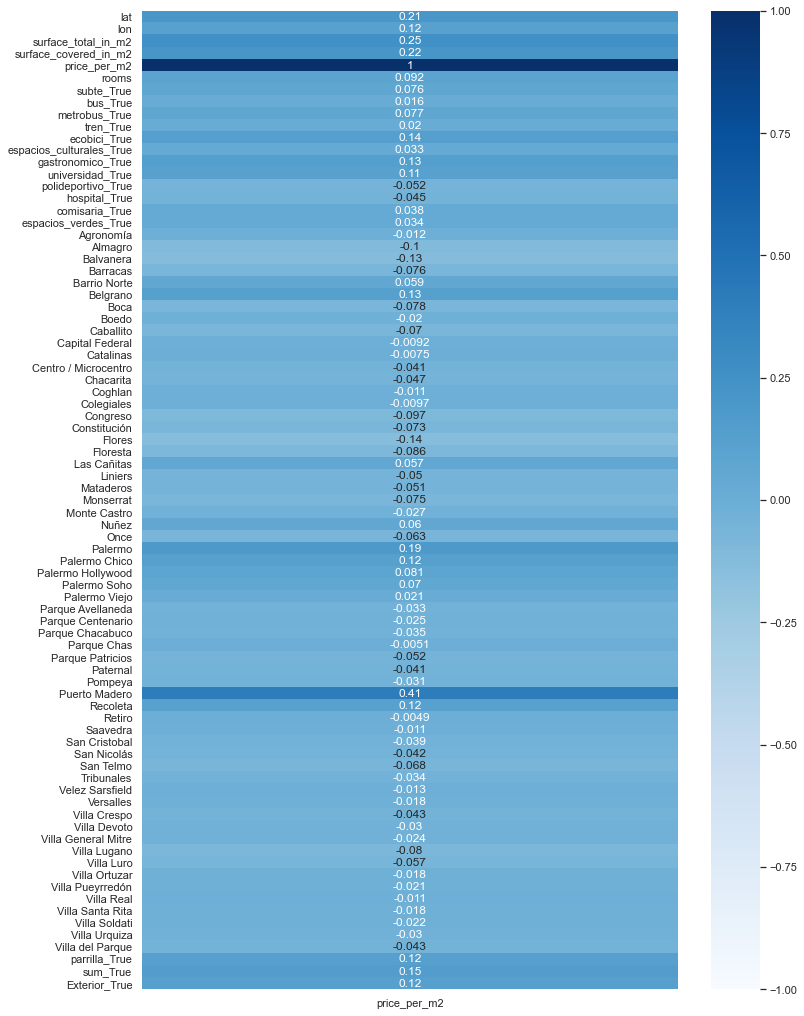

In [299]:
plt.figure(figsize=(12,18))
sns.heatmap(caba.corr()[['price_per_m2']], annot=True, vmin=-1, cmap='Blues')

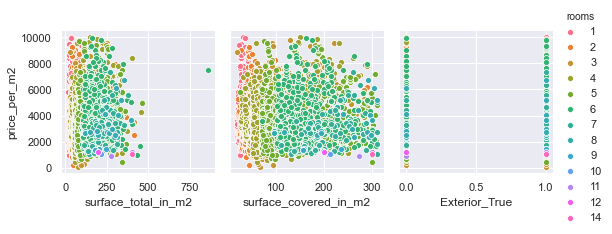

In [300]:
sns.pairplot(data=caba,hue='rooms', y_vars='price_per_m2',\
             x_vars=['surface_total_in_m2','surface_covered_in_m2','Exterior_True'])

### 13) Modelo de regresion

Combinando GridSearchCV y Pipeline vamos a crear diferentes modelos:
* Regresion Linear
* Modelo de Lasso
* Modelo de Ridge
* Modelo de Elastic Net
* Random Forest Regressor
* AdaBoosting
* Gradient Boosting
* LightGBM Regressor

Al final vamos a presentar en un dataframe cada uno de sus scores (R2) para verificar cual fue el modelo que tuvo una mejor performance.

In [326]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn import linear_model
set_config(display='diagram')

In [303]:
caba.columns

Index(['lat', 'lon', 'surface_total_in_m2', 'surface_covered_in_m2',
       'price_per_m2', 'rooms', 'subte_True', 'bus_True', 'metrobus_True',
       'tren_True', 'ecobici_True', 'espacios_culturales_True',
       'gastronomico_True', 'universidad_True', 'polideportivo_True',
       'hospital_True', 'comisaria_True', 'espacios_verdes_True', 'Agronomía',
       'Almagro', 'Balvanera', 'Barracas', 'Barrio Norte', 'Belgrano', 'Boca',
       'Boedo', 'Caballito', 'Capital Federal', 'Catalinas',
       'Centro / Microcentro', 'Chacarita', 'Coghlan', 'Colegiales',
       'Congreso', 'Constitución', 'Flores', 'Floresta', 'Las Cañitas',
       'Liniers', 'Mataderos', 'Monserrat', 'Monte Castro', 'Nuñez', 'Once',
       'Palermo', 'Palermo Chico', 'Palermo Hollywood', 'Palermo Soho',
       'Palermo Viejo', 'Parque Avellaneda', 'Parque Centenario',
       'Parque Chacabuco', 'Parque Chas', 'Parque Patricios', 'Paternal',
       'Pompeya', 'Puerto Madero', 'Recoleta', 'Retiro', 'Saavedra',
    

In [304]:
caba.shape

(17203, 81)

In [305]:
X = caba.drop(columns=['price_per_m2','lat','lon'])
y = caba.price_per_m2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

folds = 5

#### Regresion Linear

In [338]:
lr = LinearRegression()

param_lr ={'normalize':[True, False]}

grid_lr = GridSearchCV(estimator=lr, param_grid=param_lr, cv=folds, scoring='r2')
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'normalize': [True, False]}, scoring='r2')

In [339]:
grid_lr.best_score_

0.45929338993029606

In [340]:
grid_lr.best_estimator_

LinearRegression()

#### Ridge

In [341]:
pasos = [('preprocesamiento', StandardScaler()),
         ('regresion', Ridge())
        ]

pipe_grid_rid = Pipeline(pasos)

param_grid_rid = [{'preprocesamiento':[StandardScaler(), None],
                   'regresion__alpha':[0.01, 0.3, 0.5, 0.7, 0.8],
                }]

grid_rid = GridSearchCV(estimator=pipe_grid_rid, param_grid=param_grid_rid, cv=folds, scoring='r2')
grid_rid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', Ridge())]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__alpha': [0.01, 0.3, 0.5, 0.7, 0.8]}],
             scoring='r2')

In [342]:
grid_rid.best_score_

0.459339411529878

In [343]:
grid_rid.best_estimator_

Pipeline(steps=[('preprocesamiento', None), ('regresion', Ridge(alpha=0.5))])

#### Lasso

In [344]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', Lasso(max_iter=5000, tol=0.001))
        ]

pipe_grid_lass = Pipeline(pasos)

param_grid_lass = [{'preprocesamiento':[StandardScaler(), None],
                    'regresion__alpha':[0.01, 0.3, 0.5, 0.7, 0.8],
                  }]

grid_lass = GridSearchCV(estimator=pipe_grid_lass, param_grid=param_grid_lass, cv=folds, scoring='r2')
grid_lass.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion',
                                        Lasso(max_iter=5000, tol=0.001))]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__alpha': [0.01, 0.3, 0.5, 0.7, 0.8]}],
             scoring='r2')

In [345]:
grid_lass.best_score_

0.4594731298211966

In [346]:
grid_lass.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion', Lasso(alpha=0.8, max_iter=5000, tol=0.001))])

#### ElasticNet

In [347]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', ElasticNet(max_iter=10000, tol=0.001))
        ]

pipe_grid_en = Pipeline(pasos)

param_grid_en = [{'preprocesamiento':[StandardScaler(), None],
                  'regresion__alpha':[0.01, 0.3, 0.5, 0.7, 0.8],
                  'regresion__l1_ratio':[0.01, 0.3, 0.5, 0.7, 0.8],
                }]

grid_en = GridSearchCV(estimator=pipe_grid_en, param_grid=param_grid_en, cv=folds, scoring='r2')
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion',
                                        ElasticNet(max_iter=10000,
                                                   tol=0.001))]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__alpha': [0.01, 0.3, 0.5, 0.7, 0.8],
                          'regresion__l1_ratio': [0.01, 0.3, 0.5, 0.7, 0.8]}],
             scoring='r2')

In [348]:
grid_en.best_score_

0.4592874219445971

In [349]:
grid_en.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 ElasticNet(alpha=0.01, l1_ratio=0.8, max_iter=10000,
                            tol=0.001))])

#### Random Forest

In [350]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', RandomForestRegressor())
        ]

pipe_grid_rf = Pipeline(pasos)

param_grid_rf = [{'preprocesamiento':[StandardScaler(), None],
                  'regresion__n_estimators': [500, 1000],
                  'regresion__max_depth': [5, 10]
                }]

grid_rf = GridSearchCV(estimator=pipe_grid_rf, param_grid=param_grid_rf, cv=folds, scoring='r2')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', RandomForestRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__max_depth': [5, 10],
                          'regresion__n_estimators': [500, 1000]}],
             scoring='r2')

In [351]:
grid_rf.best_score_

0.46544935047989505

In [352]:
grid_rf.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 RandomForestRegressor(max_depth=10, n_estimators=1000))])

#### Gradient Boosting Regressor

In [353]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', GradientBoostingRegressor())
        ]

pipe_grid_gb = Pipeline(pasos)

param_grid_gb = [{'preprocesamiento':[StandardScaler(), None],
                  'regresion__n_estimators': [500, 1000],
                  'regresion__max_depth': [5, 10]
                }]

grid_gb = GridSearchCV(estimator=pipe_grid_gb, param_grid=param_grid_gb, cv=folds, scoring='r2')
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion',
                                        GradientBoostingRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__max_depth': [5, 10],
                          'regresion__n_estimators': [500, 1000]}],
             scoring='r2')

In [354]:
grid_gb.best_score_

0.5776567569915252

In [355]:
grid_gb.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion',
                 GradientBoostingRegressor(max_depth=5, n_estimators=500))])

#### Ada Boost Regressor

In [356]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', AdaBoostRegressor())
        ]

pipe_grid_ab = Pipeline(pasos)

param_grid_ab = [{'preprocesamiento':[StandardScaler(), None],
                  'regresion__n_estimators': [500, 1000],
                  'regresion__learning_rate':[0.01, 0.1, 0.3, 1]
                }]

grid_ab = GridSearchCV(estimator=pipe_grid_ab, param_grid=param_grid_ab, cv=folds, scoring='r2')
grid_ab.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', AdaBoostRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__learning_rate': [0.01, 0.1, 0.3, 1],
                          'regresion__n_estimators': [500, 1000]}],
             scoring='r2')

In [357]:
grid_ab.best_score_

0.21319991546105088

In [358]:
grid_ab.best_estimator_

Pipeline(steps=[('preprocesamiento', None),
                ('regresion',
                 AdaBoostRegressor(learning_rate=0.01, n_estimators=500))])

#### LightGBM Regressor

In [359]:
pasos = [('preprocesamiento', StandardScaler()),\
         ('regresion', LGBMRegressor())
        ]

pipe_grid_lg = Pipeline(pasos)

param_grid_lg = [{'preprocesamiento':[StandardScaler(), None],
                  'regresion__n_estimators': [500, 100],
                  'regresion__learning_rate':[0.01, 0.1, 0.3, 1]
                }]

grid_lg = GridSearchCV(estimator=pipe_grid_lg, param_grid=param_grid_lg, cv=folds, scoring='r2')
grid_lg.fit(X_train, y_train)

C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\lightgbm\sklearn.py", line 743, in fit
    callbacks=callbacks)
  File "C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\Lucas\.conda\envs\dhdsblend\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=param

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento', StandardScaler()),
                                       ('regresion', LGBMRegressor())]),
             param_grid=[{'preprocesamiento': [StandardScaler(), None],
                          'regresion__learning_rate': [0.01, 0.1, 0.3, 1],
                          'regresion__n_estimators': [500, 100]}],
             scoring='r2')

In [360]:
grid_lg.best_score_

0.5874483826418688

In [361]:
grid_lg.best_estimator_

Pipeline(steps=[('preprocesamiento', StandardScaler()),
                ('regresion', LGBMRegressor(n_estimators=500))])

### 14) Resultado de los modelos

In [363]:
resultados = pd.DataFrame({'Modelos':['Regresion Linear', 'Ridge', 'Lasso', 'Elastic Net','Random', 'Gradient Boost', 'AdaBoost', 'LightGBM'],
                           'R2':[grid_lr.best_score_, grid_rid.best_score_, grid_lass.best_score_, grid_en.best_score_, grid_rf.best_score_, grid_gb.best_score_,\
                                 grid_ab.best_score_, grid_lg.best_score_]
                         })
resultados.sort_values(by='R2', ascending=False)

,Modelos,R2
7,LightGBM,0.587448
5,Gradient Boost,0.577657
4,Random,0.465449
2,Lasso,0.459473
1,Ridge,0.459339
0,Regresion Linear,0.459293
3,Elastic Net,0.459287
6,AdaBoost,0.213200
